In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from collections import Counter
import glob
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import train
from random import shuffle
import imp
import os
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
%matplotlib inline

Using TensorFlow backend.


In [4]:
characters = [k.split('/')[2] for k in glob.glob('./characters/*') if len([p for p in glob.glob(k+'/*') if 'edited' in p or 'pic_vid' in p]) > 290]
map_characters = dict(enumerate(characters))
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}

In [2]:
imp.reload(train)
## Just creating dataset
X_train, X_test, y_train, y_test = train.get_dataset(save=True)

Train (14220, 64, 64, 3) (14220, 18)
Test (2510, 64, 64, 3) (2510, 18)
principal_skinner : 1012 train pictures & 164 test pictures
moe_szyslak : 1010 train pictures & 166 test pictures
homer_simpson : 1003 train pictures & 173 test pictures
ned_flanders : 1003 train pictures & 173 test pictures
bart_simpson : 1002 train pictures & 174 test pictures
lisa_simpson : 1000 train pictures & 176 test pictures
marge_simpson : 991 train pictures & 185 test pictures
krusty_the_clown : 986 train pictures & 190 test pictures
charles_montgomery_burns : 983 train pictures & 193 test pictures
milhouse_van_houten : 895 train pictures & 152 test pictures
chief_wiggum : 829 train pictures & 145 test pictures
abraham_grampa_simpson : 806 train pictures & 120 test pictures
sideshow_bob : 765 train pictures & 140 test pictures
apu_nahasapeemapetilon : 462 train pictures & 80 test pictures
kent_brockman : 412 train pictures & 76 test pictures
edna_krabappel : 388 train pictures & 73 test pictures
comic_book

#### Four convulational layers

##### Same pictures training/testing

In [20]:
## Training in the notebook
# X_train, X_test, y_train, y_test = train.get_dataset()
# model, opt = train.create_model_four_conv(X_train.shape[1:])
# model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])
# model, history = train.training(model, X_train, X_test, y_train, y_test, data_augmentation=True, callback=True, six_conv=True)

## Training on AWS
# X_train, X_test, y_train, y_test = train.get_dataset(load=True)
# model = keras.models.load_model('./models/model_08_06.h5')
# with open('./models/history06_19.pkl', 'rb') as f:
#     history = pickle.load(f)
    
## Loading from callbacks
imp.reload(train)
model = train.load_model_from_checkpoint('./models/weights.best_6conv2.hdf5', six_conv=True)
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')

Train (14220, 64, 64, 3) (14220, 18)
Test (2510, 64, 64, 3) (2510, 18)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.97      0.93      0.95       120
  apu_nahasapeemapetilon       0.99      0.99      0.99        80
            bart_simpson       0.94      0.93      0.93       174
charles_montgomery_burns       0.96      0.92      0.94       193
            chief_wiggum       0.99      0.97      0.98       145
          comic_book_guy       0.95      0.92      0.93        77
          edna_krabappel       0.94      0.90      0.92        73
           homer_simpson       0.91      0.96      0.93       173
           kent_brockman       0.95      0.93      0.94        76
        krusty_the_clown       0.99      0.98      0.98       190
            lisa_simpson       0.93      0.93      0.93       176
           marge_simpson       1.00      0.97      0.98       185
     milhouse_van_houten       0.96      1.00      0.98       152
   

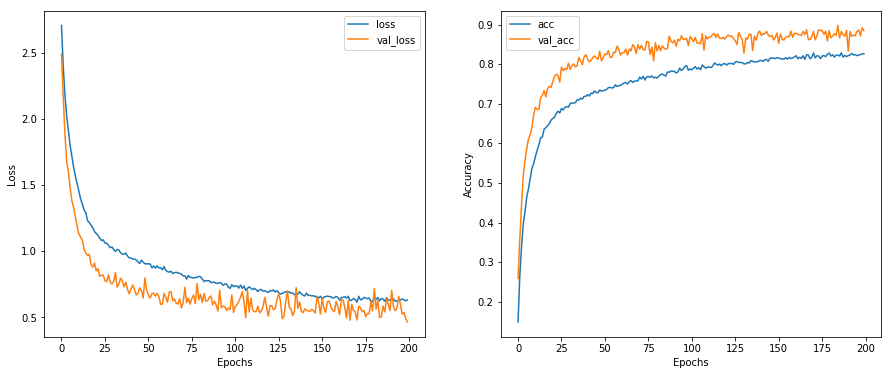

In [282]:
epochs= range(200)
f, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(epochs, history['loss'], label='loss')
ax[0].plot(epochs, history['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, history['acc'], label='acc')
ax[1].plot(epochs, history['val_acc'], label='val_acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

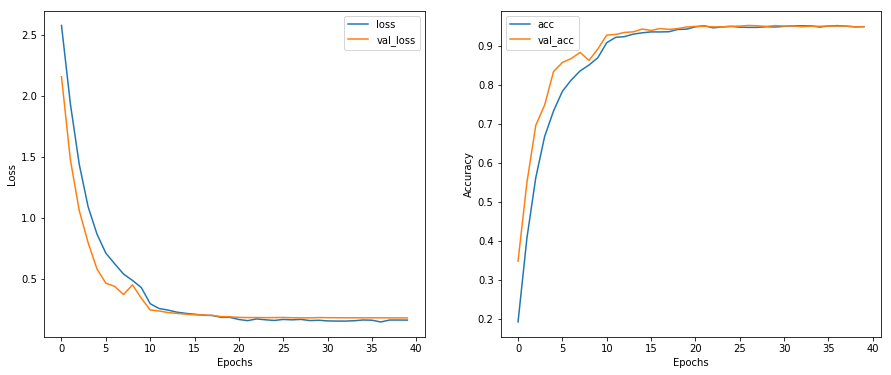

In [24]:
with open('./models/history06_19.pkl', 'rb') as f:
    history = pickle.load(f)
epochs= range(40)
f, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(epochs, history['loss'], label='loss')
ax[0].plot(epochs, history['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, history['acc'], label='acc')
ax[1].plot(epochs, history['val_acc'], label='val_acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

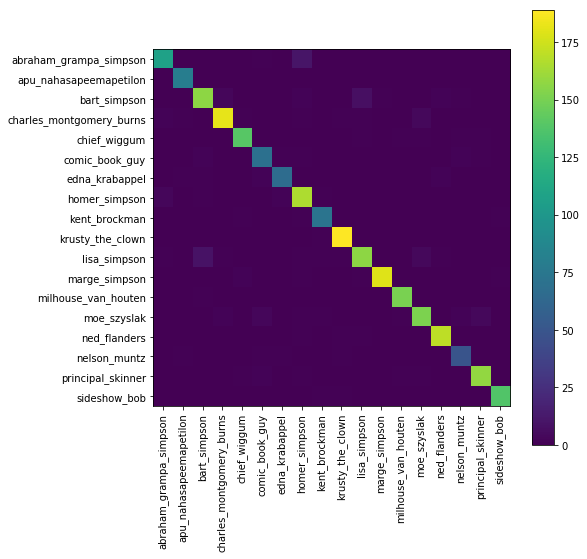

In [17]:
plt.figure(figsize=(8,8))
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

##### With BGR/RGB

In [249]:
X_test2 = []
for img in X_test:
    X_test2.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
X_test2 = np.array(X_test2)
model = keras.models.load_model('./models/model_BGR.h5')
y_pred = model.predict(X_test2)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.86      0.95      0.91        86
            bart_simpson       0.95      0.82      0.88       179
charles_montgomery_burns       0.93      0.86      0.89       135
           homer_simpson       0.88      0.90      0.89       171
        krusty_the_clown       0.94      0.97      0.95        92
            lisa_simpson       0.85      0.94      0.89       188
           marge_simpson       0.99      0.97      0.98       167
             moe_szyslak       0.94      0.95      0.94       171
            ned_flanders       1.00      0.92      0.96       102
            sideshow_bob       0.86      0.97      0.91        67

             avg / total       0.92      0.92      0.92      1358



#### Six convolutional layers 

In [19]:
## Training on AWS
X_train, X_test, y_train, y_test = train.get_dataset(load=True)
model = keras.models.load_model('./models/model_sixconv.h5')
with open('./models/history2.pkl', 'rb') as f:
    history = pickle.load(f)
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')

Train (6893, 64, 64, 3) (6893, 10)
Test (766, 64, 64, 3) (766, 10)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.93      0.95      0.94        58
            bart_simpson       0.83      0.89      0.86        89
charles_montgomery_burns       0.87      0.68      0.76        76
           homer_simpson       0.90      0.94      0.92       147
        krusty_the_clown       0.91      0.98      0.94        41
            lisa_simpson       0.90      0.85      0.87       102
           marge_simpson       0.96      0.95      0.96       108
             moe_szyslak       0.80      0.89      0.84        45
            ned_flanders       0.93      0.86      0.89        59
            sideshow_bob       0.84      0.93      0.88        41

             avg / total       0.89      0.89      0.89       766



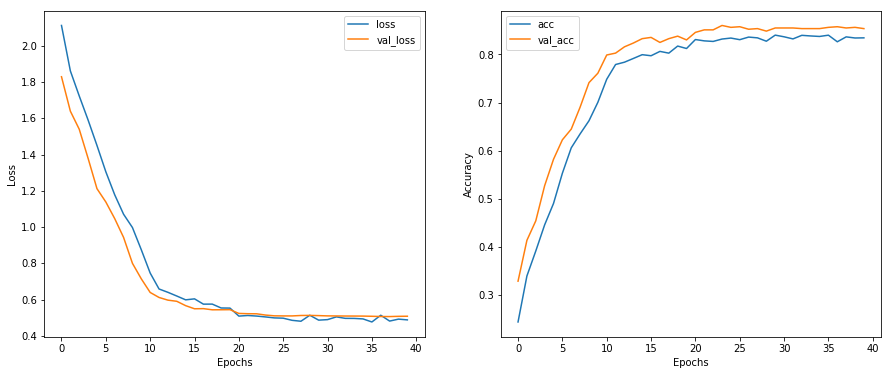

In [21]:
epochs= range(40)
f, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(epochs, history['loss'], label='loss')
ax[0].plot(epochs, history['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, history['acc'], label='acc')
ax[1].plot(epochs, history['val_acc'], label='val_acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

In [22]:
## -> More overfitting

#### Predict from url

In [340]:
import urllib
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def plot_and_predict(url, all_perc=False):
    image = url_to_image(url)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    pic = cv2.resize(image, (pic_size,pic_size))
    a = model.predict_proba(pic.reshape(1, pic_size, pic_size,3))[0]
    if all_perc:
        print('\n'.join(['{} : {}%'.format(map_characters[i], round(k*100)) for i,k in sorted(enumerate(a), key=lambda x:x[1], reverse=True)]))
    else:
        return map_characters[np.argmax(a)].replace('_',' ').title()

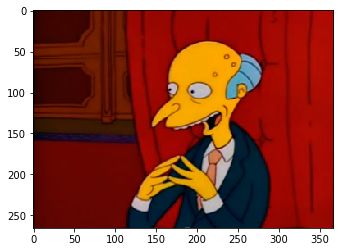

1/1 [==============================] - 0s


'Charles Montgomery Burns'

In [345]:
url = "https://vignette3.wikia.nocookie.net/simpsons/images/2/25/Adult_burns.jpg/revision/latest?cb=20111012170021"
plot_and_predict(url)

#### Generating and plotting

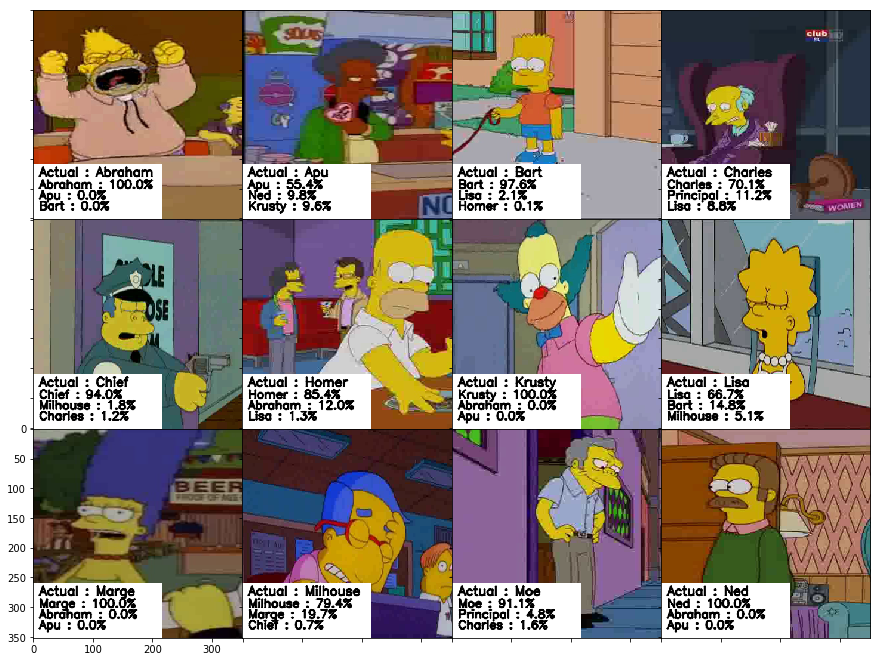

In [451]:
from mpl_toolkits.axes_grid1 import AxesGrid
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'homer_simpson', 
    6: 'krusty_the_clown', 7: 'lisa_simpson', 8: 'marge_simpson', 
    9: 'milhouse_van_houten', 10: 'moe_szyslak', 11: 'ned_flanders', 
    12: 'principal_skinner', 13: 'sideshow_bob'}

F = plt.figure(1, (15,20))
grid = AxesGrid(F, 111,  # similar to subplot(141)
                nrows_ncols=(3, 4),
                axes_pad=0,
                label_mode="1")

for i in range(12):
    char = map_characters[i]
    image = cv2.imread(np.random.choice([k for k in glob.glob('./characters/%s/*' % char) if 'pic_vid' in k]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pic = cv2.resize(image, (64, 64)).astype('float32') / 255.
    a = model.predict(pic.reshape(1, 64, 64,3))[0]
    actual = char.split('_')[0].title()
#     pred = map_characters[np.argmax(a)].split('_')[0].title()
    text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
       key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    img = cv2.resize(img, (352, 352))
    cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
    for k, t in enumerate(text):
        cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)
#     cv2.putText(img, 'Pred : %s' % pred, (100, 310), font, 0.7,(0,0,0),2,cv2.LINE_AA)    
    grid[i].imshow(img)

#### Finding a threshold

In [287]:
y_pred = model.predict(X_test, verbose=0)
comp = np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1)
index_good, index_false = [i for i, x in enumerate(comp) if x], [i for i, x in enumerate(comp) if not x]

In [290]:
max_good = np.max(y_pred[index_good], axis=1)
max_wrong = np.max(y_pred[index_false], axis=1)
diff_good = np.diff(np.sort(y_pred[index_good], axis=1)[:, 16:])
diff_wrong = np.diff(np.sort(y_pred[index_false], axis=1)[:, 16:])
std_good = np.std(y_pred[index_good], axis=1)
std_wrong = np.std(y_pred[index_false], axis=1)

print("For good predictions : Max : {:.2f}, Difference Two First : {:.3f}, STD : {:.2f}".format(np.mean(max_good),
                                                                            np.mean(diff_good),
                                                                            np.mean(std_good)))
print("For wrong predictions : Max : {:.2f}, Difference Two First : {:.3f}, STD : {:.2f}".format(np.mean(max_wrong),
                                                                             np.mean(diff_wrong),
                                                                            np.mean(std_wrong)))

For good predictions : Max : 0.84, Difference Two First : 0.786, STD : 0.19
For wrong predictions : Max : 0.37, Difference Two First : 0.200, STD : 0.09


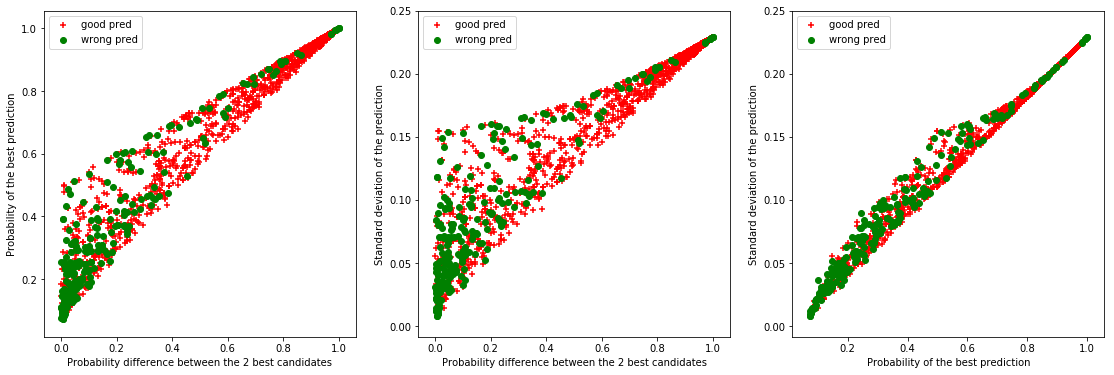

In [291]:
f, ax = plt.subplots(ncols=3, figsize=(19,6))
ax[0].scatter(x = diff_good, y= max_good, c='red', marker='+', label = 'good pred')
ax[0].scatter(x = diff_wrong, y= max_wrong, c='green', marker='o', label = 'wrong pred')
ax[0].legend()
ax[0].set_xlabel('Probability difference between the 2 best candidates')
ax[0].set_ylabel('Probability of the best prediction')

ax[1].scatter(x = diff_good, y= std_good, c='red', marker='+', label = 'good pred')
ax[1].scatter(x = diff_wrong, y= std_wrong, c='green', marker='o', label = 'wrong pred')
ax[1].legend()
ax[1].set_xlabel('Probability difference between the 2 best candidates')
ax[1].set_ylabel('Standard deviation of the prediction')

ax[2].scatter(x = max_good, y= std_good, c='red', marker='+', label = 'good pred')
ax[2].scatter(x = max_wrong, y= std_wrong, c='green', marker='o', label = 'wrong pred')
ax[2].legend()
ax[2].set_xlabel('Probability of the best prediction')
ax[2].set_ylabel('Standard deviation of the prediction')

In [284]:
## FOR LISA
id_lisa = 10
index_lisa = [i for i, x in enumerate(np.argmax(y_pred, axis= 1) == id_lisa) if x]
index_good_lisa, index_wrong_lisa = [k for k in index_lisa if k in index_good], [k for k in index_lisa if k in index_false]

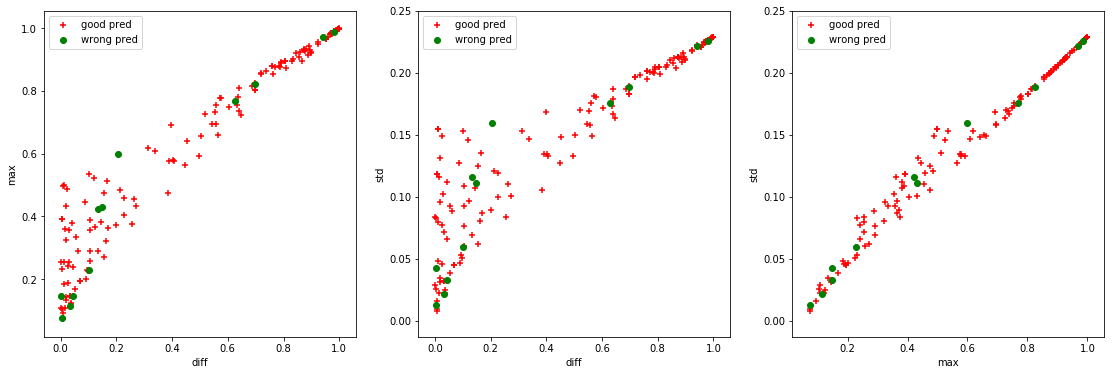

In [286]:
dicts = {'max':{'good':np.max(y_pred[index_good_lisa], axis=1), 
                'wrong': np.max(y_pred[index_wrong_lisa], axis=1)},
        'diff':{'good':np.diff(np.sort(y_pred[index_good_lisa], axis=1)[:, 16:]), 
                'wrong': np.diff(np.sort(y_pred[index_wrong_lisa], axis=1)[:, 16:])}, 
        'std':{'good': np.std(y_pred[index_good_lisa], axis=1), 
                'wrong': np.std(y_pred[index_wrong_lisa], axis=1)}}

import itertools
chosen = list(itertools.combinations(dicts.items(),2))
f, ax = plt.subplots(ncols=3, figsize=(19,6))
for i in range(3):
    ax[i].scatter(x = chosen[i][0][1]['good'], y= chosen[i][1][1]['good'], 
                  c='red', marker='+', label = 'good pred')
    ax[i].scatter(x = chosen[i][0][1]['wrong'], y= chosen[i][1][1]['wrong'], 
                  c='green', marker='o', label = 'wrong pred')
    ax[i].legend()
    ax[i].set_xlabel(chosen[i][0][0])
    ax[i].set_ylabel(chosen[i][1][0])

#### Threshold and Precision/Recall

In [407]:
y_pred = model.predict(X_test, verbose=0)
indices = [round(k*0.01,2) for k in range(0, 100, 5)] + [0.99]
pos_characters = {cl: {k:[] for k in indices} for cl in map_characters}
for k in indices:
    for i, e in enumerate(y_pred):
        if np.max(e) > k:
            pos_characters[np.argmax(e)][k].append(int(np.argmax(e) == np.argmax(y_test[i])))
pos_characters['ALL'] = {k:np.sum([pos_characters[cl][k] for cl in pos_characters]) for k in indices}                 

In [458]:
indices = [round(k*0.01, 2)+round(p*0.01,2) for k,p in zip(range(0, 20), range(0, 100, 5))]
pos_characters_2 = {cl: {k:[] for k in indices} for cl in map_characters}
for k in indices:
    for i, e in enumerate(y_pred):
        if np.std(e)+np.max(e) > k:
            pos_characters_2[np.argmax(e)][k].append(int(np.argmax(e) == np.argmax(y_test[i])))
pos_characters_2['ALL'] = {k:np.sum([pos_characters_2[cl][k] for cl in pos_characters_2]) for k in indices}                 

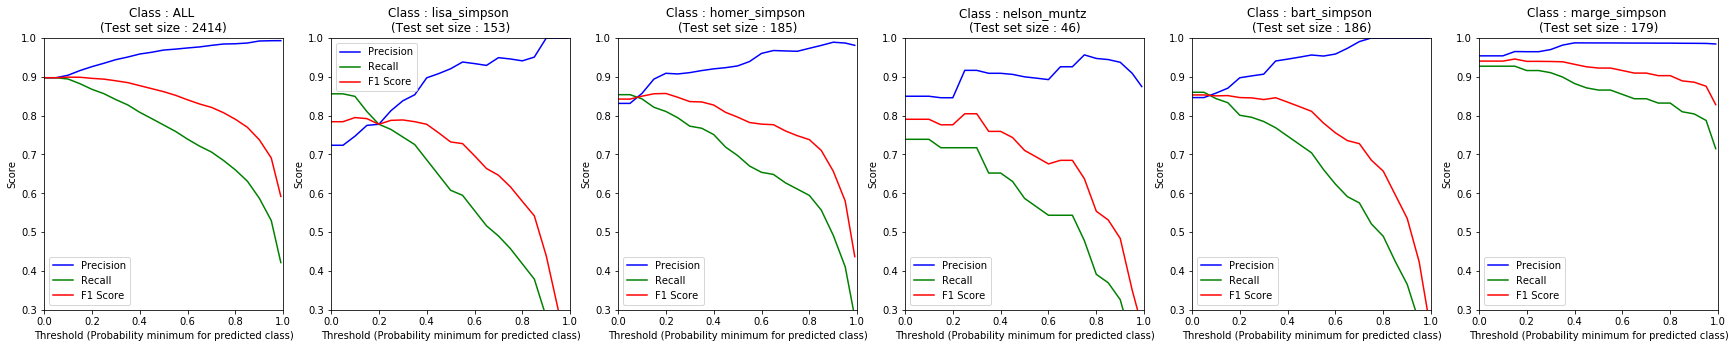

In [432]:
classes_plot = ["ALL", 10, 7, 15, 2, 11]
tr = {"ALL": np.argmax(y_test, axis=1)}
f, ax = plt.subplots(ncols=len(classes_plot), figsize=(len(classes_plot)*5, 5))
for i, cl_plt in enumerate(classes_plot):
    precision = {k:np.sum(pos_characters[cl_plt][k])/len(pos_characters[cl_plt][k]) for k in indices}
    recall = {k:np.sum(pos_characters[cl_plt][k])/np.sum(np.argmax(y_test, axis=1)==tr.get(cl_plt, cl_plt))for k in indices}
    f1_score = {k:(2*precision[k]*recall[k])/(precision[k]+recall[k]) for k in indices}
    x,y = zip(*sorted(precision.items()))
    ax[i].plot(x, y, color='blue', label='Precision')
    x,y = zip(*sorted(recall.items()))
    ax[i].plot(x, y, label='Recall', color='green')
    x,y = zip(*sorted(f1_score.items()))
    ax[i].plot(x, y, color='red', label='F1 Score')
    _ = ax[i].set_xlim((0,1))
    _ = ax[i].set_ylabel('Score')
    _ = ax[i].set_xlabel('Threshold (Probability minimum for predicted class)')
    _ = ax[i].set_ylim((0.3,1))
    _ = ax[i].legend()
    _ = ax[i].set_title('Class : %s \n(Test set size : %d)' % (map_characters.get(cl_plt, cl_plt), np.sum(np.argmax(y_test, axis=1) == tr.get(cl_plt, cl_plt))))

#### Attention maps

/Users/alexandreattia/Desktop/Work/workenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Working on filters: [6]


/Users/alexandreattia/Desktop/Work/workenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Working on filters: [3]


/Users/alexandreattia/Desktop/Work/workenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Working on filters: [1]


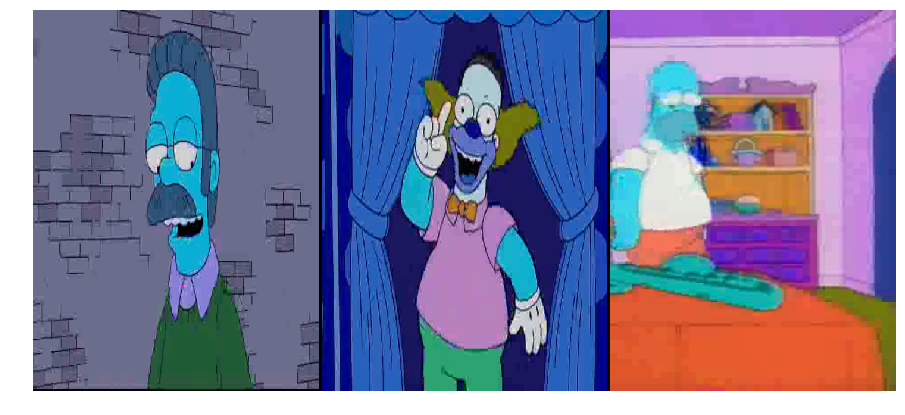

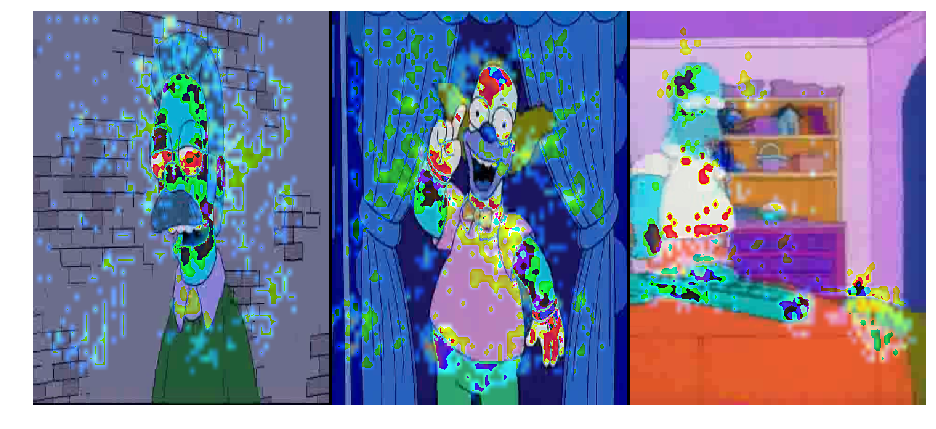

In [122]:
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

from vis.utils import utils
from vis.visualization import visualize_saliency

# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_idx = [idx for idx, layer in enumerate(model.layers)][16]

# Images corresponding to tiger, penguin, dumbbell, speedboat, spider
image_paths = np.random.choice(np.concatenate([glob.glob('./characters/%s/*.jpg' % k) for k in map_characters.values()]), 3)

heatmaps = []
true_img = []
d=[]
for path in image_paths:
    seed_img = utils.load_img(path, target_size=(64, 64)).astype('float32') / 255.
    seed_img  = seed_img.reshape((1, 64, 64, 3))
    pred_class = np.argmax(model.predict(seed_img))

    # Here we are asking it to show attention such that prob of `pred_class` is maximized.
    heatmap = visualize_saliency(model, layer_idx, [pred_class], seed_img.reshape((64, 64, 3)))
    heatmaps.append(heatmap * 255.) 
    true_img.append(cv2.resize(cv2.imread(path),(480,640)))
    d.append(cv2.resize(cv2.imread(path),(480,640)) + cv2.resize(heatmap,(480,640)))

plt.figure(figsize=(14,5))
plt.axis('off')
plt.imshow(utils.stitch_images(true_img))
plt.show()

plt.figure(figsize=(14,5))
plt.axis('off')
plt.imshow(utils.stitch_images(d))
plt.show()

#### Visualizing weights

#### Create video

In [182]:
m, s = 5, 7
cap = cv2.VideoCapture("video1.avi") 
nb_frames = 2500

fps = cap.get(cv2.CAP_PROP_FPS)
cap.set(1, fps*(m*60+s))
for i in range(4000):
    ret, frame = cap.read()
    if i % 15 == 0:
        img = cv2.resize(frame, (64, 64)).astype('float32') / 255.
        a = model.predict(img.reshape((-1, 64, 64, 3)), verbose=0)[0]
        text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
               key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    im = frame
    cv2.rectangle(im, (int(frame.shape[1] * 0.6),int(frame.shape[0] * 0.7)),(frame.shape[1],frame.shape[0]),(255,255,255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    for k, t in enumerate(text):
        cv2.putText(im,t,
                    ((int(frame.shape[1] * 0.6 + 10), int(frame.shape[0] * 0.7 + 20 +k*25))), 
                    font, 0.8,(0,0,0),2,cv2.LINE_AA)
    cv2.imwrite('./video_created/vid_{0:0=4d}.jpg'.format(i), im)
 
# !ffmpeg -f image2 -r 25 -i ./video_created/vid_%04d.jpg -vcodec mpeg4 -y ./video_created/movie3.mp4

# for i in glob.glob('./video_created/*.jpg'):
#     os.remove(i)

error: /opt/local/var/macports/build/_opt_local_var_macports_sources_rsync.macports.org_release_tarballs_ports_graphics_opencv/opencv/work/opencv-3.2.0/modules/imgproc/src/imgwarp.cpp:3492: error: (-215) ssize.width > 0 && ssize.height > 0 in function resize


In [488]:
!ffmpeg -f image2 -r 25 -i ./video_created/video_%05d.jpg -vcodec mpeg4 -y ./video_created/movie4.mp4

ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 8.0.0 (clang-800.0.42.1)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-libtheora --enable-libschroedinger --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --disable-outdev=xv --enable-audiotoolbox --enable-sdl2 --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-vda --enable-videotoolbox --arch=x86_64 --enable-yasm --enable-libx265 --enable-gpl --enable-postproc --enable-libx264 --enable-libxvid
  libavutil      55. 34.101 / 55. 34.101
  libavcodec     57. 64.101 / 57. 64.101
  libavformat   